In [ ]:
import numpy as np, torch, time
from Ctubes.curve_parametrizations import torus_knot_parameterization
from Ctubes.geometry_utils import regular_polygon
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_all
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())
PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demo
This notebook shows how to define a `CTube` object given a square as `Generatrix` and a torus unknot as `Directrix`. 

The directrix of the resulting tube is then optimized for tube closure.

In [25]:
# Generatrix: regular N-gon
N = 4
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

: 

In [ ]:
# Directrix: trefoil knot
closed_curve = True
K_per_base_curve = 5
n_fold_symm = 3
K = K_per_base_curve * n_fold_symm + 1
K_to_M_factor = 13
M = K_to_M_factor * (K - 1) + 1

# Define the spline
ts_disc_curve = torch.linspace(0.0, 2.0 * PI, K)
cps_ref = torus_knot_parameterization(ts_disc_curve, p=1, q=3, r=1, R=2)

In [12]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)

tube = CTube(directrix, generatrix)

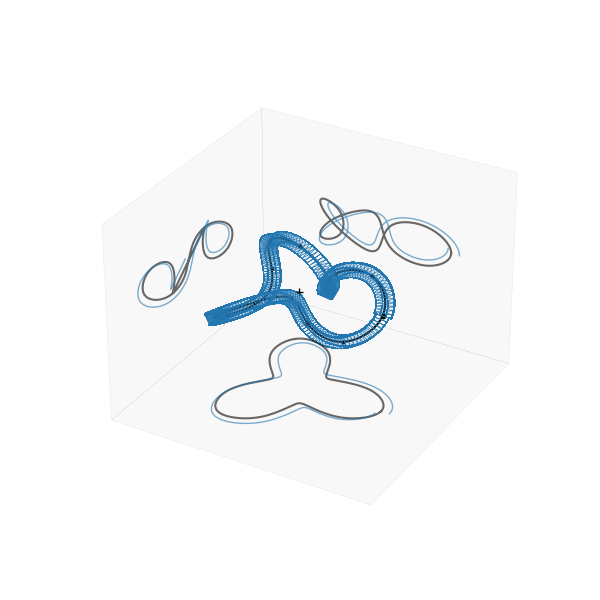

In [14]:
fig, ax = tube.plot_3d()

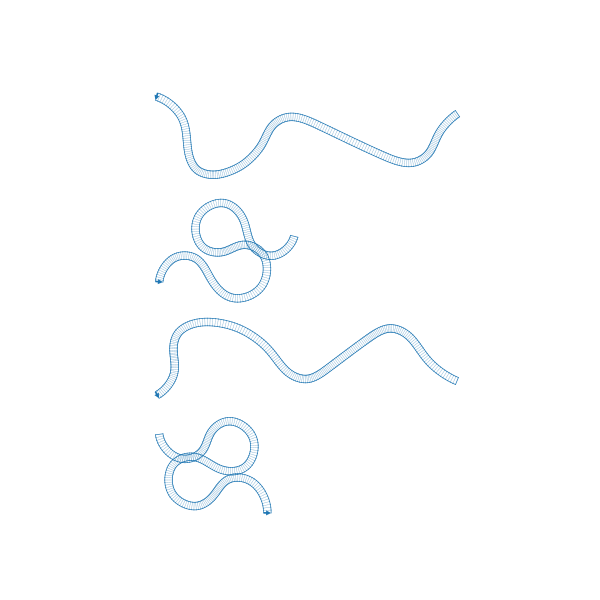

In [15]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [16]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1.0 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1e2 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_all(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [17]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000000000
join_ends                               : 1.2891829375
smooth_plane_normal_diffs               : 0.0001243827
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(1.2893)

In [18]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []
dofs = opt_prob.get_dof_indices_cps()
fixed_indices += dofs[:3] + dofs[-3:]  # fix endpoints
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 6 parameters.


In [20]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           45     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  1.28931D+00    |proj g|=  4.49742D+00

At iterate    1    f=  1.15746D-03    |proj g|=  1.30331D-01

At iterate    2    f=  1.55281D-04    |proj g|=  6.60148D-03

At iterate    3    f=  1.52696D-04    |proj g|=  1.08914D-04

At iterate    4    f=  1.52679D-04    |proj g|=  1.38242D-04

At iterate    5    f=  1.52504D-04    |proj g|=  1.03558D-03

At iterate    6    f=  1.52192D-04    |proj g|=  2.09797D-03

At iterate    7    f=  1.51687D-04    |proj g|=  3.22278D-03

At iterate    8    f=  1.50991D-04    |proj g|=  3.48642D-03

At iterate    9    f=  1.49773D-04    |proj g|=  2.24117D-03

At iterate   10    f=  1.49153D-04    |proj g|=  3.83349D-04

At iterate   11    f=  1.49004D-04    |proj g|=  9.40919D-04

At iterate   12    f=  1.48954D-04    |proj g|=  7.94111D-05

At iterate   13    f=  1.4

In [21]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000327993
join_ends                               : 0.0000002883
smooth_plane_normal_diffs               : 0.0001156285
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(0.0001)

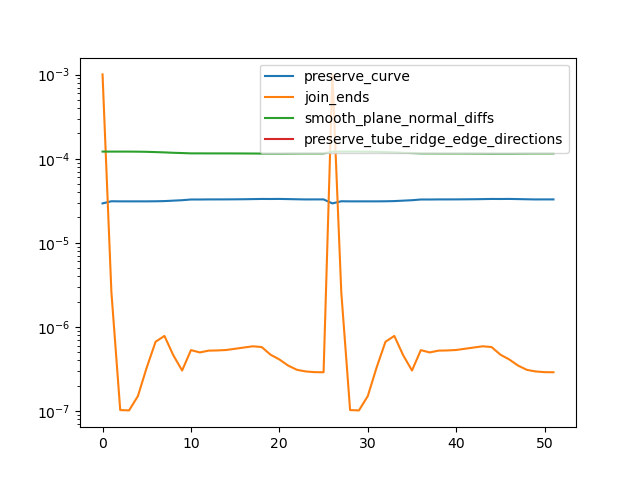

In [22]:
fig, ax = opt_prob.plot_objective_history()

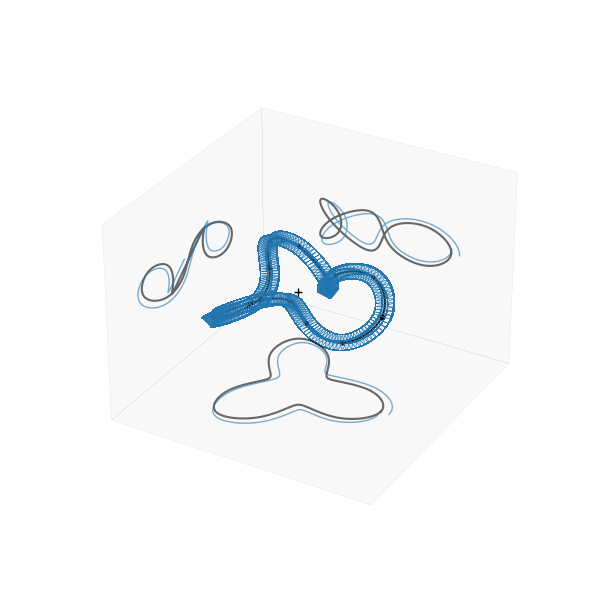

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

KeyError: 'buttons'

In [ ]:
fig, ax = opt_prob.plot_3d()

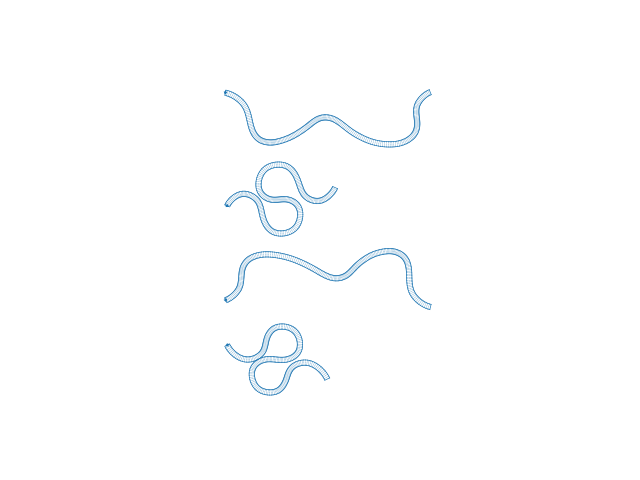

In [24]:
fig, ax = opt_prob.plot_unrolled_strips()